In [1]:
import numba as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.linalg import eig


In [2]:
N = 10
L = 59 #nm
mass = 0.067 #au
omega = 10.0 #meV
au_energy = 27211.6
ab = 0.05292 #nm to Bohr radius

n_els = (2*N)**2 #liczba elementów
n_glob = (2*N+1)**2 #liczba węzłów

x_nlg = np.concatenate([np.linspace(-L/2,L/2,2*N+1) for i in range(2*N+1)])
y_nlg = np.repeat(np.linspace(-L/2,L/2,2*N+1),2*N+1)
nlg = np.empty((n_els,4), dtype = int) #dla każdego elementu 4 węzły
#mesh = np.empty((2*N+1, 2*N+1))     #[i, j] = [y, x]
for k in range(n_els): #pętla po elementach
    for i in range(2):
        nlg[k,i] = k + i + k//(2*N) #dla wezla 1 i 2
        nlg[k,i+2] = nlg[k,i] + 2*N+1 #dla wezla 3 i 4

In [3]:
df =pd.DataFrame(index = range(4*n_els),columns = ['Nr elementu', 'Nr lokalny węzła', 'Nr globalny węzła', 'x węzła', 'y węzła'])
for k in range(n_els):
    for i in range(4):
        df.iloc[4*k+i] = [k,i,nlg[k,i],x_nlg[nlg[k,i]],y_nlg[nlg[k,i]]]
df

,Nr elementu,Nr lokalny węzła,Nr globalny węzła,x węzła,y węzła
0,0,0,0,-29.5,-29.5
1,0,1,1,-26.55,-29.5
2,0,2,21,-29.5,-26.55
3,0,3,22,-26.55,-26.55
4,1,0,1,-26.55,-29.5
...,...,...,...,...,...
1595,398,3,439,26.55,29.5
1596,399,0,418,26.55,26.55
1597,399,1,419,29.5,26.55
1598,399,2,439,26.55,29.5


In [4]:
def f(i,ksi):
    if i == 0:
        return (1-ksi)/2;
    elif i == 1:
        return (1+ksi)/2;
    else:
        print('[ERROR] Unrecognized function')
        exit(-1)
def g(i,ksi_vec):
    if i == 0:
        return f(0,ksi_vec[0])*f(0,ksi_vec[1])
    elif i == 1:
        return f(1,ksi_vec[0])*f(0,ksi_vec[1])
    elif i == 2:
        return f(0,ksi_vec[0])*f(1,ksi_vec[1])
    elif i == 3:
        return f(1,ksi_vec[0])*f(1,ksi_vec[1])
    else:
        print('[ERROR] Unrecognized function')
        exit(-1)

Psi_nlg = np.empty(n_glob)
for n in range(n_glob): Psi_nlg[n] = np.exp(-mass*omega/au_energy/2.*((x_nlg[n]/ab)**2+(y_nlg[n]/ab)**2))
ksi_step = 0.1
ksi0_tab = np.arange(-1,1 + ksi_step,ksi_step)
ksi1_tab = np.arange(-1,1 + ksi_step,ksi_step)


x = np.empty((n_els, np.size(ksi0_tab)))
y = np.empty((n_els, np.size(ksi1_tab)))
Psi = np.zeros((n_els, np.size(ksi1_tab), np.size(ksi0_tab)))

for k in range(n_els):
    for m in range (np.size(ksi0_tab)):
        for n in range(np.size(ksi1_tab)):
            x[k,m] = x_nlg[nlg[k,0]]/2*(1-ksi0_tab[m]) + x_nlg[nlg[k,1]]/2*(1+ksi0_tab[m])
            y[k,n] = y_nlg[nlg[k,0]]/2*(1-ksi1_tab[n]) + y_nlg[nlg[k,2]]/2*(1+ksi1_tab[n])
            for i in range(4):
                Psi[k,n,m] += Psi_nlg[nlg[k,i]]*g(i,[ksi0_tab[m], ksi1_tab[n]])

for i in range(2*N):
    Psi_new = np.concatenate(Psi[i*2*N:(1+i)*2*N], axis = 1)
    if i == 0:
        Psi_r = Psi_new
    else:
        Psi_r = np.concatenate((Psi_r, Psi_new), axis = 0)

Psi_r = np.delete(Psi_r, [np.size(ksi0_tab)*i for i in range(1,2*N)], axis = 1)
Psi_r = np.delete(Psi_r, [np.size(ksi1_tab)*i for i in range(1,2*N)], axis = 0)

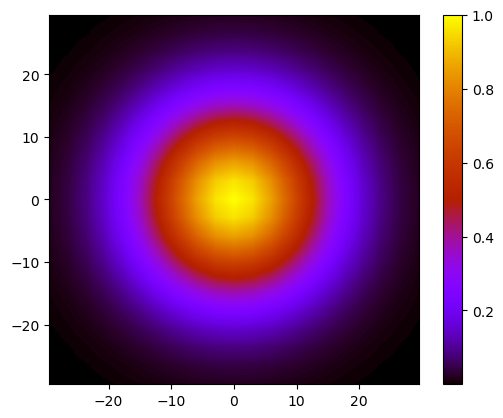

In [5]:
plt.imshow(Psi_r, origin='lower', cmap='gnuplot', extent=[-L/2,L/2,-L/2,L/2], interpolation=None)
plt.colorbar()

# Zadanie 3
 Policzyć i wypisać elementy lokalnej macierzy przekrywania

In [6]:
#trójpunktowa kwadratura gaussa
# L=100/ab #w jednostkach atomowych
# L_ab = L/ab
# N=2
a=(L/ab)/(2*N) #w jednostkach atomowych
p = np.array([-math.sqrt(3/5),0,math.sqrt(3/5)])
w = np.array([5/9,8/9,5/9])

#lokalna macierz przekrywania
s = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        for l in range(3):
            for n in range(3):
                s[i,j] += (a**2)/4*(w[l]*w[n]*g(j,[p[l], p[n]])*g(i,[p[l], p[n]]))
print('s:\n',s)
print('s do porownania ze skryptem:')
s2=s/((a**2)/4)*9
print(s2)

s:
 [[345.27239038 172.63619519 172.63619519  86.31809759]
 [172.63619519 345.27239038  86.31809759 172.63619519]
 [172.63619519  86.31809759 345.27239038 172.63619519]
 [ 86.31809759 172.63619519 172.63619519 345.27239038]]
s do porownania ze skryptem:
[[4. 2. 2. 1.]
 [2. 4. 1. 2.]
 [2. 1. 4. 2.]
 [1. 2. 2. 4.]]


# Zadanie 4
Policzyć i wypisać elementy lokalnej macierzy przekrywania

In [7]:
delta=0.01
def der1(ii,pl,pn):
    return((g(ii,[pl,pn+delta])-g(ii,[pl,pn-delta]))/(2*delta))
def der2(ii,pl,pn):
    return((g(ii,[pl+delta,pn])-g(ii,[pl-delta,pn]))/(2*delta))

t = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        for l in range(3):
            for n in range(3):
                t[i,j] += (1/(2*mass))*(w[l]*w[n]*(der1(j,p[l],p[n])*der1(i,p[l],p[n])+der2(j,p[l],p[n])*der2(i,p[l],p[n])))
print('t:\n',t)
t2=t*6*2*mass
print('t do porownania ze skryptem:\n',t2)

t:
 [[ 4.97512438 -1.24378109 -1.24378109 -2.48756219]
 [-1.24378109  4.97512438 -2.48756219 -1.24378109]
 [-1.24378109 -2.48756219  4.97512438 -1.24378109]
 [-2.48756219 -1.24378109 -1.24378109  4.97512438]]
t do porownania ze skryptem:
 [[ 4. -1. -1. -2.]
 [-1.  4. -2. -1.]
 [-1. -2.  4. -1.]
 [-2. -1. -1.  4.]]


In [8]:

#lokalne macierze przekrywania dla energii potencjalnej są różne dla każdego elementu
v = np.zeros((n_els,4,4))
omega=10/au_energy

for k in range(n_els):
    for i in range(4):
        for j in range(4):
            calka=0
            for l in range(3):
                for n in range(3):
                    xc=(x_nlg[nlg[k,0]]/ab*(1-p[n])+x_nlg[nlg[k,1]]/ab*(1+p[n]))/2
                    yc=(y_nlg[nlg[k,0]]/ab*(1-p[l])+y_nlg[nlg[k,2]]/ab*(1+p[l]))/2
                    calka=calka+(((xc)**2+(yc)**2)*g(j,[p[l], p[n]])*g(i,[p[l], p[n]]))*w[l]*w[n]
            v[k,i,j]=calka*((a**2)/4)*mass*(omega**2)/2

#sprawdzenie dla wezla 11
k=10
for i in range(4):
    print(x_nlg[nlg[k,i]],y_nlg[nlg[k,i]],(v[k,i,i]/s[i,i])*au_energy) #wspolrzedne wezla

0.0 -29.5 36.41933721846231
2.950000000000003 -29.5 32.785054617880476
0.0 -26.55 36.61061525007188
2.950000000000003 -26.55 32.97633264949005


# Zadanie 6
składamy macierze globalne

In [9]:
S = np.zeros((n_glob, n_glob))
H = np.zeros((n_glob, n_glob))

for k in range(n_els):
    for i in range(4):
        for j in range(4):
          S[nlg[k,i],nlg[k,j]] += s[i,j]
          H[nlg[k,i],nlg[k,j]] += t[i,j] + v[k,i,j]

# print('\n'.join([''.join(['{:1}'.format(H) for H in row])
#       for row in H]))


Narzucamy warunek znikania wszystkich funkcji falowych na brzegu

In [10]:
for i in range(2*N+1):#dolny brzeg
  H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0
  S[i,i] = 1
  H[i,i] = -1410
for i in range(2*N*(2*N+1), (2*N+1)*(2*N+1)):#gorny brzeg
  H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0
  S[i,i] = 1
  H[i,i] = -1410
for i in range(0, (2*N+1)*(2*N+1),(2*N+1)):#lewy brzeg
  H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0
  S[i,i] = 1
  H[i,i] = -1410
for i in range(2*N, (2*N+1)*(2*N+1),(2*N+1)):#prawy brzeg
  H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0
  S[i,i] = 1
  H[i,i] = -1410


In [11]:
def select_eig_vectors(eig_vals, eig_vectors):
  j=0
  new_eig_vals = np.zeros(len(eig_vals))
  new_eig_vectors = np.zeros((len(eig_vals), len(eig_vals)))
  a_list = list(range(0, len(eig_vals)))
  a_list = [x for _, x in sorted(zip(eig_vals, a_list))]

  for i in range(len(eig_vals)):
    new_eig_vals[i] = eig_vals[a_list[i]]
    new_eig_vectors[:,i] = eig_vectors[:,a_list[i]]
  for i in range(len(eig_vals)):
    if eig_vals[i] > 0:
      j+=1
  return new_eig_vals[len(eig_vals)-j:len(eig_vals)],  new_eig_vectors[:,len(eig_vals)-j:len(eig_vals)]



rozwiazujemy równanie własne Hc = ESc

In [12]:
eig_vals, eig_vectors = eig(H, S)
selectedEigVals, selectedEigVectors= select_eig_vectors(eig_vals.real,eig_vectors)

plotowanie funkcji falowych dla 6 najniższychzszych stanów

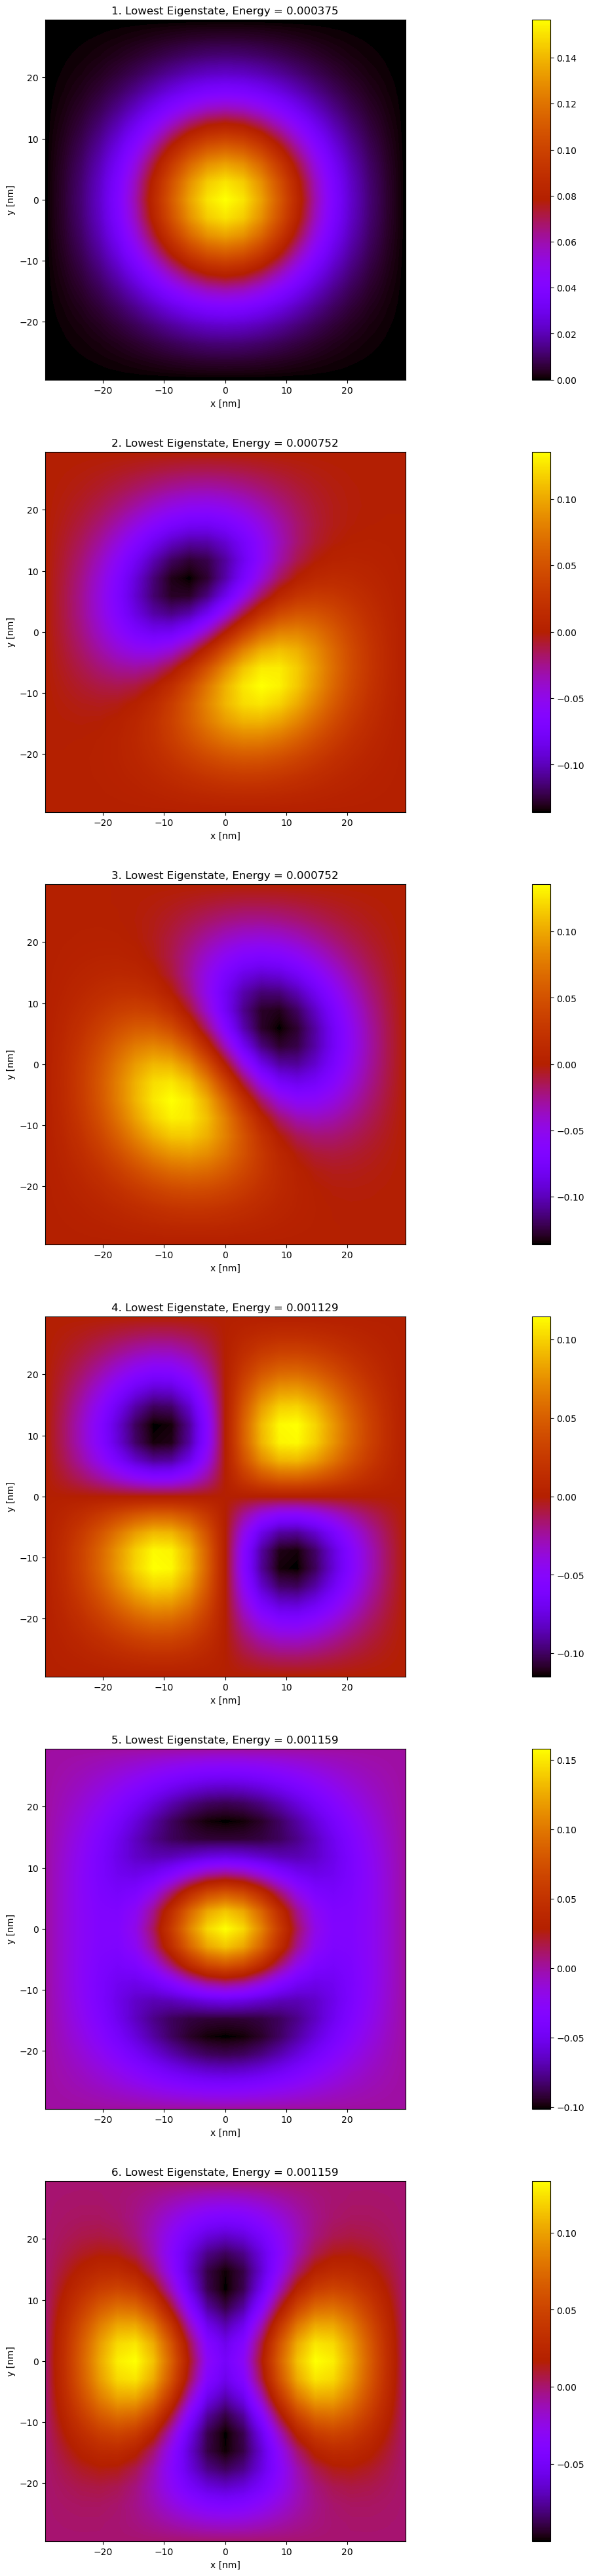

In [13]:

fig, axs = plt.subplots(6, 1, figsize=(50, 50))

for E_num in range(6):
  Psi_nlg = np.empty(n_glob)
  for n in range(n_glob): Psi_nlg[n] = selectedEigVectors[n,E_num]
  ksi_step = 0.1
  ksi0_tab = np.arange(-1,1 + ksi_step,ksi_step)
  ksi1_tab = np.arange(-1,1 + ksi_step,ksi_step)


  x = np.empty((n_els, np.size(ksi0_tab)))
  y = np.empty((n_els, np.size(ksi1_tab)))
  Psi = np.zeros((n_els, np.size(ksi1_tab), np.size(ksi0_tab)))

  for k in range(n_els):
      for m in range (np.size(ksi0_tab)):
          for n in range(np.size(ksi1_tab)):
              x[k,m] = x_nlg[nlg[k,0]]/2*(1-ksi0_tab[m]) + x_nlg[nlg[k,1]]/2*(1+ksi0_tab[m])
              y[k,n] = y_nlg[nlg[k,0]]/2*(1-ksi1_tab[n]) + y_nlg[nlg[k,2]]/2*(1+ksi1_tab[n])
              for i in range(4):
                  Psi[k,n,m] += Psi_nlg[nlg[k,i]]*g(i,[ksi0_tab[m], ksi1_tab[n]])

  for i in range(2*N):
      Psi_new = np.concatenate(Psi[i*2*N:(1+i)*2*N], axis = 1)
      if i == 0:
          Psi_r = Psi_new
      else:
          Psi_r = np.concatenate((Psi_r, Psi_new), axis = 0)

  Psi_r = np.delete(Psi_r, [np.size(ksi0_tab)*i for i in range(1,2*N)], axis = 1)
  Psi_r = np.delete(Psi_r, [np.size(ksi1_tab)*i for i in range(1,2*N)], axis = 0)

  axs[E_num].set_title('{0:.0f}. Lowest Eigenstate, Energy = {1:.6f}'.format((E_num+1),selectedEigVals[E_num]))
  axs[E_num].set_ylabel('y [nm]')
  axs[E_num].set_xlabel('x [nm]')
  pcm = axs[E_num].imshow(Psi_r, origin='lower', cmap='gnuplot', extent=[-L/2,L/2,-L/2,L/2], interpolation=None)
  plt.colorbar(pcm, ax=axs[E_num])



# Zadanie 7

In [14]:
dt = 100
A_matr = S - dt/(2j)*H
B_matr = S + dt/(2j)*H

nsteps = 1000
d = np.zeros((nsteps, np.size(selectedEigVectors[:,0])), dtype = complex)
d[0] = selectedEigVectors[:,0] + selectedEigVectors[:,1]

for i in range(nsteps-1):
    d[i+1] = np.linalg.solve(A_matr, np.dot(B_matr,d[i]))

#selectedEigVectors[n,E_num]

In [16]:
#Lokalne x
x_loc = np.zeros((n_els,4,4))

for k in range(n_els):
    for i in range(4):
        for j in range(4):
            for l in range(3):
                for n in range(3):
                    xc=(x_nlg[nlg[k,0]]/ab*(1-p[n])+x_nlg[nlg[k,1]]/ab*(1+p[n]))/2
                    x_loc[k,i,j] += (a**2)/4*(w[l]*w[n]*g(j,[p[l], p[n]])*xc*g(i,[p[l], p[n]]))

In [17]:
#Globalne x
X = np.zeros((n_glob, n_glob))

for k in range(n_els):
    for i in range(4):
        for j in range(4):
          X[nlg[k,i],nlg[k,j]] += x_loc[k,i,j]

# print('\n'.join([''.join(['{:1}'.format(H) for H in row])
#       for row in H]))

In [20]:
n_glob

441

In [26]:
time = np.arange(0, nsteps*dt,dt)
x_of_t = np.zeros(nsteps, dtype=complex)
for i in range(nsteps):
    x_of_t[i] = np.dot(np.conjugate(np.transpose(d[i])),np.dot(X,d[i]))

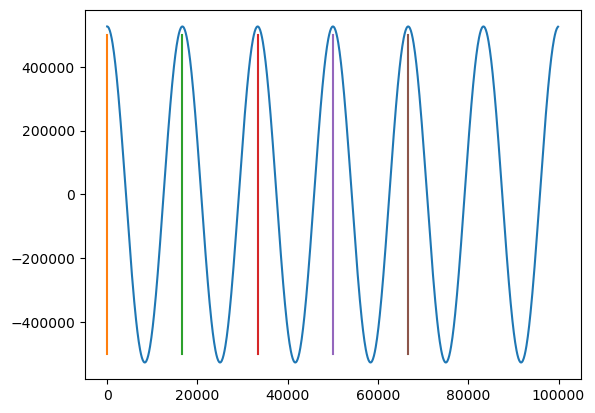

In [31]:
fig, ax = plt.subplots()
ax.plot(time, x_of_t.real)
deltaE = selectedEigVals[1] - selectedEigVals[0]
T = 2*np.pi/deltaE
for i in range(5):
    ax.plot([i*T, i*T], [-500000, 500000])

(441,)